In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("#Sunplots")
    plt.grid(True)

In [2]:
df = pd.read_csv("hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt", sep='\s+')
df.drop(columns=['X', 'Y', 'error', 'error.1', 'ID'], inplace=True)
df.loc[df.Sharp > 0, 'Sharp'] = 2
df.loc[df.Sharp < 0, 'Sharp'] = 0
df.loc[df.Sharp == 0, 'Sharp'] = 1
df

,F606W,F814W,Chi,Sharp
0,28.197,27.127,6.106,2.0
1,20.843,19.815,10.690,2.0
2,27.014,26.068,10.651,2.0
3,30.193,28.270,4.059,1.0
4,28.935,28.941,4.274,1.0
...,...,...,...,...
51475,26.895,25.602,9.508,2.0
51476,23.152,22.662,8.823,1.0
51477,27.209,27.130,4.311,2.0
51478,28.235,26.477,6.173,2.0


In [3]:
X = df[df.columns[:-1]].to_numpy()
y = df[df.columns[-1]].to_numpy().reshape(1, -1)

In [4]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes=3)[0]
#y = labels.reshape(-1, 3)
y.shape

(51480, 3)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=len(df.columns[:-1]), activation='relu'),
 tf.keras.layers.Dense(256, activation="relu"),
 tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
 tf.keras.layers.Dense(3, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3328      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 46,707
Trainable params: 46,707
Non-trainable params: 0
____________________________________________________

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# metrics=['mae']
# metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [8]:
%%time
stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, mode='auto')
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=stopping)

Epoch 1/100
1030/1030 [==============================] - 2s 2ms/step - loss: 0.6707 - accuracy: 0.6849 - val_loss: 0.6637 - val_accuracy: 0.7060
Epoch 2/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.6656 - accuracy: 0.7003 - val_loss: 0.6619 - val_accuracy: 0.7102
Epoch 3/100
1030/1030 [==============================] - 2s 1ms/step - loss: 0.6638 - accuracy: 0.7051 - val_loss: 0.6606 - val_accuracy: 0.7156
Epoch 4/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.6631 - accuracy: 0.7069 - val_loss: 0.6597 - val_accuracy: 0.7147
Epoch 5/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.6616 - accuracy: 0.7099 - val_loss: 0.6594 - val_accuracy: 0.7166
Epoch 6/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.6618 - accuracy: 0.7099 - val_loss: 0.6610 - val_accuracy: 0.7086
Epoch 7/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.6610 - accuracy: 0.7107 - val_loss: 0.6598 - val_ac

In [9]:
_, accuracy = model.evaluate(X_val, y_val, verbose=0)

In [10]:
accuracy

0.7198008894920349

In [11]:
prediction = model.predict(X_test)

In [12]:
pred = prediction.argmax(axis=1)

In [24]:
(pred == y_test.argmax(axis=1)).sum()

7473

In [13]:
y_test.shape

(10296, 3)

In [14]:
(pred == 0).sum(), (pred == 1).sum(), (pred == 2).sum()

(0, 2901, 7395)

In [15]:
(y_test.argmax(axis=1) == 0).sum(), (y_test.argmax(axis=1) == 1).sum(), (y_test.argmax(axis=1) == 2).sum()

(0, 4504, 5792)

In [34]:
y_test

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [16]:
(prediction > 0).sum(), (prediction < 0).sum(), (prediction == 0).sum()

(10275, 0, 21)

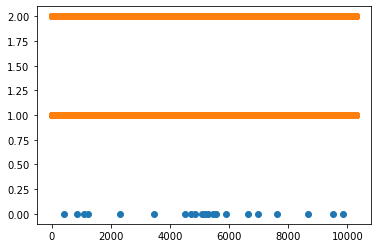

In [17]:
plt.scatter(np.arange(len(prediction)),prediction)
plt.scatter(np.arange(len(y_test)), y_test)